# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Loading Data

In [3]:
building = pd.read_csv('building_metadata.csv')
train = pd.read_csv('train.csv')
weather_train = pd.read_csv('weather_train.csv')

In [4]:
test =pd.read_csv('test.csv')
weather_test = pd.read_csv('weather_test.csv')

# Overview of datasets

## 1. Size of datasets

In [4]:
# Shape of each dataframe
print('Size of building_metadata:',building.shape)
print('Size of train:',train.shape)
print('Size of weather_train:',weather_train.shape)
print('Size of test:',test.shape)
print('Size of weather_test:',weather_test.shape)

Size of building_metadata: (1449, 6)
Size of train: (20216100, 4)
Size of weather_train: (139773, 9)
Size of test: (41697600, 4)
Size of weather_test: (277243, 9)


In [5]:
train.head()  

building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0

In [6]:
train['timestamp'].tail() #2016-01-01  -2016-12-31

20216095    2016-12-31 23:00:00
20216096    2016-12-31 23:00:00
20216097    2016-12-31 23:00:00
20216098    2016-12-31 23:00:00
20216099    2016-12-31 23:00:00
Name: timestamp, dtype: object

In [7]:
weather_train.head()

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-01-01 03:00:00             21.1             2.0   
4        0  2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6

In [8]:
building.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

## 2. Merge datasets by foreign keys

In [6]:
# Merge train, weather_train via foreign key from building 
# train---building_id----building
# train---site_id,timestamp---weather_train
train = train.merge(building,left_on = ['building_id'], right_on=['building_id'],how='left')

In [10]:
train.head()

building_id  meter            timestamp  meter_reading  site_id  \
0            0      0  2016-01-01 00:00:00            0.0        0   
1            1      0  2016-01-01 00:00:00            0.0        0   
2            2      0  2016-01-01 00:00:00            0.0        0   
3            3      0  2016-01-01 00:00:00            0.0        0   
4            4      0  2016-01-01 00:00:00            0.0        0   

  primary_use  square_feet  year_built  floor_count  
0   Education         7432      2008.0          NaN  
1   Education         2720      2004.0          NaN  
2   Education         5376      1991.0          NaN  
3   Education        23685      2002.0          NaN  
4   Education       116607      1975.0          NaN

In [7]:
train = train.merge(weather_train, left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')

In [8]:
train.head()

building_id  meter            timestamp  meter_reading  site_id  \
0            0      0  2016-01-01 00:00:00            0.0        0   
1            1      0  2016-01-01 00:00:00            0.0        0   
2            2      0  2016-01-01 00:00:00            0.0        0   
3            3      0  2016-01-01 00:00:00            0.0        0   
4            4      0  2016-01-01 00:00:00            0.0        0   

  primary_use  square_feet  year_built  floor_count  air_temperature  \
0   Education         7432      2008.0          NaN             25.0   
1   Education         2720      2004.0          NaN             25.0   
2   Education         5376      1991.0          NaN             25.0   
3   Education        23685      2002.0          NaN             25.0   
4   Education       116607      1975.0          NaN             25.0   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0             6.0             20.0                NaN              1019.7   
1             6.0             20.0                NaN              1019.7   
2             6.0             20.0                NaN              1019.7   
3             6.0             20.0                NaN              1019.7   
4             6.0             20.0                NaN              1019.7   

   wind_direction  wind_speed  
0             0.0         0.0  
1             0.0         0.0  
2             0.0         0.0  
3             0.0         0.0  
4             0.0         0.0

In [13]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [9]:
test  = test.merge(building,left_on = ['building_id'], right_on=['building_id'],how='left')
test = test.merge(weather_test,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')

## 3. Review data types

In [15]:
train.dtypes 

building_id             int64
meter                   int64
timestamp              object
meter_reading         float64
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

In [16]:
test.dtypes

row_id                  int64
building_id             int64
meter                   int64
timestamp              object
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

problems: \
(1) timestamp---datetime \
(2) meter--{0,1,2,3}\
(3) others are too way too much 

Function to assign proper data types for all numerical variables to reduce memory usage

In [10]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
train= reduce_mem_usage(train)

Mem. usage decreased to 1041.10 Mb (60.3% reduction)


In [19]:
train.dtypes

building_id             int16
meter                    int8
timestamp              object
meter_reading         float32
site_id                  int8
primary_use            object
square_feet             int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtype: object

In [12]:
test= reduce_mem_usage(test)

Mem. usage decreased to 2147.36 Mb (60.3% reduction)


In [21]:
test.dtypes

row_id                  int32
building_id             int16
meter                    int8
timestamp              object
site_id                  int8
primary_use            object
square_feet             int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtype: object

Set timestamp as index for the training set\
Change its data type from object to datetime

In [13]:
train=train.set_index('timestamp')

In [14]:
train.index = pd.to_datetime(train.index)

In [15]:
train.head()

building_id  meter  meter_reading  site_id primary_use  \
timestamp                                                            
2016-01-01            0      0            0.0        0   Education   
2016-01-01            1      0            0.0        0   Education   
2016-01-01            2      0            0.0        0   Education   
2016-01-01            3      0            0.0        0   Education   
2016-01-01            4      0            0.0        0   Education   

            square_feet  year_built  floor_count  air_temperature  \
timestamp                                                           
2016-01-01         7432      2008.0          NaN             25.0   
2016-01-01         2720      2004.0          NaN             25.0   
2016-01-01         5376      1991.0          NaN             25.0   
2016-01-01        23685      2002.0          NaN             25.0   
2016-01-01       116607      1975.0          NaN             25.0   

            cloud_coverage  dew_temperature  precip_depth_1_hr  \
timestamp                                                        
2016-01-01             6.0             20.0                NaN   
2016-01-01             6.0             20.0                NaN   
2016-01-01             6.0             20.0                NaN   
2016-01-01             6.0             20.0                NaN   
2016-01-01             6.0             20.0                NaN   

            sea_level_pressure  wind_direction  wind_speed  
timestamp                                                   
2016-01-01              1019.5             0.0         0.0  
2016-01-01              1019.5             0.0         0.0  
2016-01-01              1019.5             0.0         0.0  
2016-01-01              1019.5             0.0         0.0  
2016-01-01              1019.5             0.0         0.0

In [16]:
train.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               ...
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=20216100, freq=None)

For numerical columns, both training and test datasets have been assigined with proper datatypes and saved aound 60% memory usage.\
For categorical features, \
train: timestamp has been set as index with datetime data type, primary_use will be processed later\
test: hasn't process any categorical features

## 4. Cleaning Data
### 4.1 Missing Values and percentage

In [17]:
# Find out variables with missing values
train_na_vars = [var for var in train.columns if train[var].isnull().mean()>0]

In [18]:
train_na_vars

['year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [19]:
train_na_values = train[train_na_vars].isnull().mean()

In [20]:
train_na_values 

year_built            0.599900
floor_count           0.826528
air_temperature       0.004781
cloud_coverage        0.436551
dew_temperature       0.004953
precip_depth_1_hr     0.185447
sea_level_pressure    0.060925
wind_direction        0.071678
wind_speed            0.007107
dtype: float64

In [21]:
test_na_vars = [var for var in test.columns if test[var].isnull().mean()>0]

In [22]:
test_na_vars

['year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [23]:
test_na_values = test[test_na_vars].isnull().mean()

In [24]:
test_na_values

year_built            0.589916
floor_count           0.826050
air_temperature       0.005322
cloud_coverage        0.468664
dew_temperature       0.006255
precip_depth_1_hr     0.187099
sea_level_pressure    0.060359
wind_direction        0.071435
wind_speed            0.007245
dtype: float64

In [25]:
missing_train=pd.DataFrame(np.round(train_na_values*100,3),columns=['Train Missing Percentage'])

In [26]:
#missing_train

In [27]:
missing_test=pd.DataFrame(np.round(test_na_values*100,3),columns=['Test Missing Percentage'])

In [28]:
#missing_test

In [29]:
missing=pd.concat([missing_train,missing_test],axis=1).reset_index()

In [30]:
missing=missing.rename(columns={'index':'Variables'}).sort_values(by='Train Missing Percentage',ascending= False)

In [31]:
missing

Variables  Train Missing Percentage  Test Missing Percentage
1         floor_count                    82.653                   82.605
0          year_built                    59.990                   58.992
3      cloud_coverage                    43.655                   46.866
5   precip_depth_1_hr                    18.545                   18.710
7      wind_direction                     7.168                    7.143
6  sea_level_pressure                     6.093                    6.036
8          wind_speed                     0.711                    0.724
4     dew_temperature                     0.495                    0.625
2     air_temperature                     0.478                    0.532

Building info: floor_count, year_build missed a lot -------Intuitively,these two features are relating to building energy consumption.Should later be imputed.\
Weather info:  cloud_coverage,precip_depth_1_hr missed -----Needs more inspection

### 4.2 Plottings - Mean Meter Reading vs Features
Distribution\
Any abnormalities, Outliers

In [41]:
train.columns.values

array(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'], dtype=object)

#### (1) Building Features

Plot a rough one to get a sense of the meter reading.

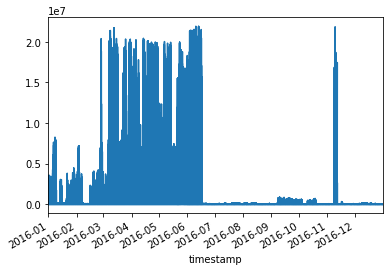

In [42]:
train['meter_reading'].plot()

Meter reading encountered a sharp drop to zero in July, then another peak value in the mid November. \
The reason can be from 'building_id', 'meter', 'meter_reading', 'site_id', 'primary_use'.

##### <1> Site_id

In [44]:
site_ids

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')

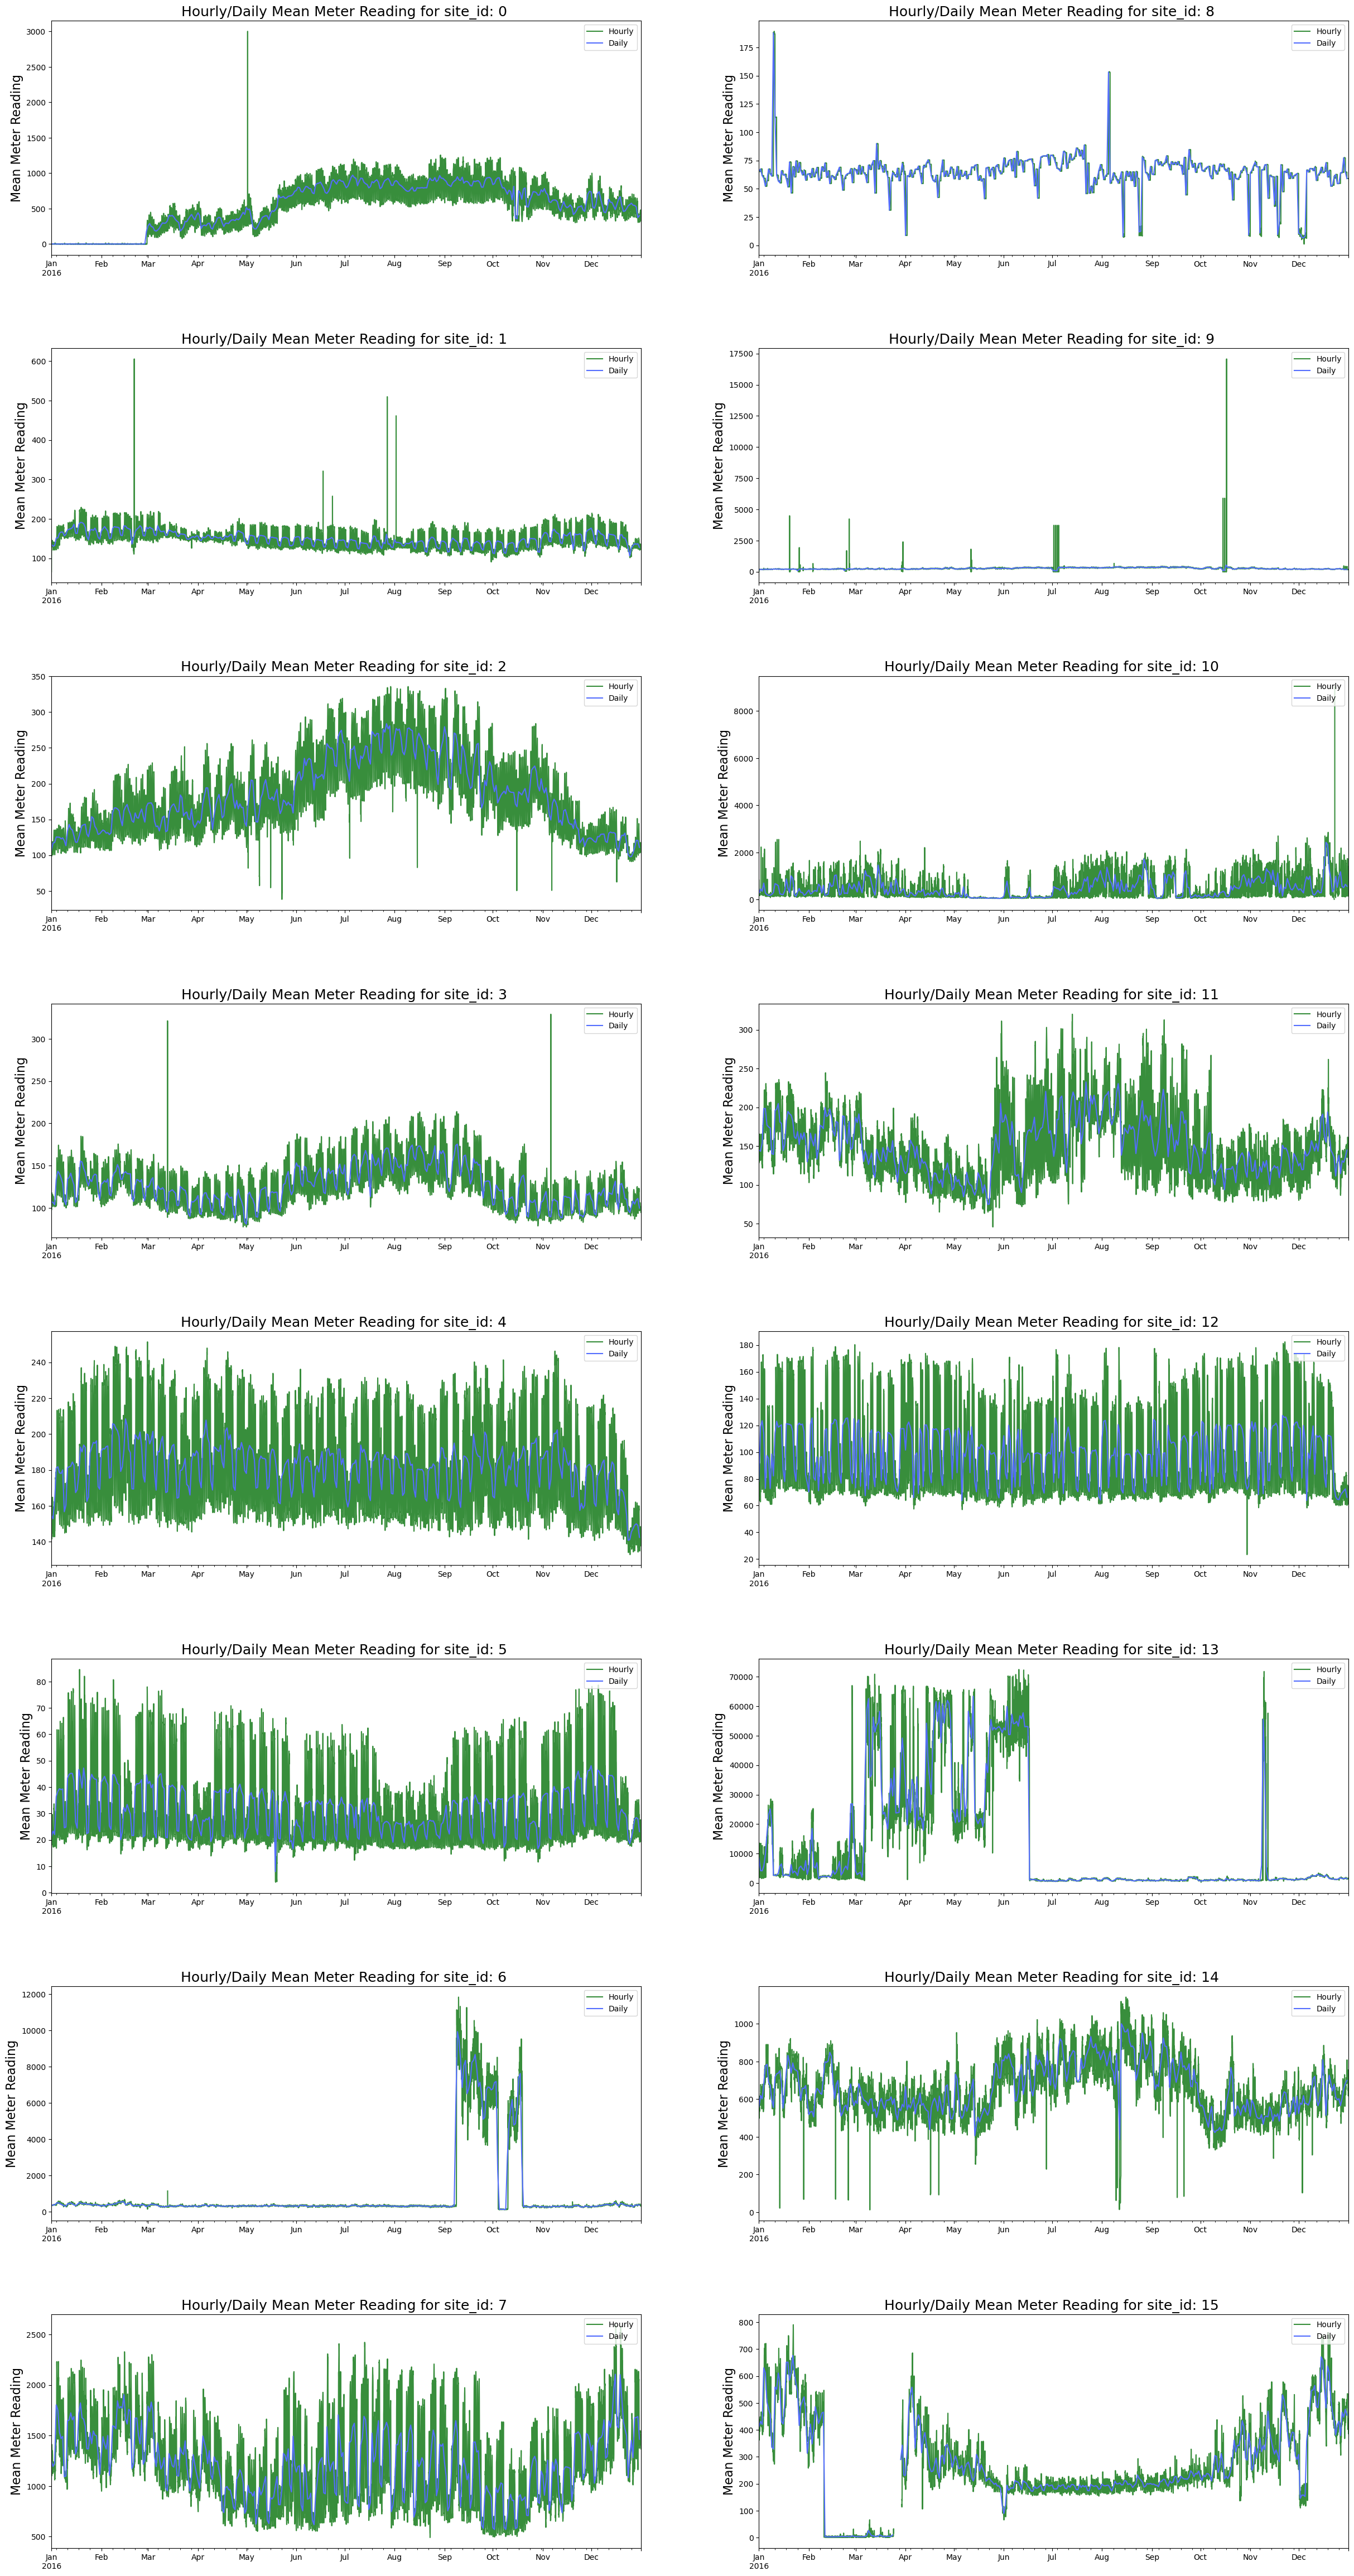

In [83]:
rows=8
cols=2
figure,axes = plt.subplots(rows,cols,figsize=(30,60),dpi=100)  # Set the whole figure size and subplots numbers
site_ids = train['site_id'].value_counts().index.sort_values().to_list()  # save all site ids in a list
for i in range(len(site_ids)):
    train[train['site_id']==i]['meter_reading'].resample(rule='H').mean().plot(ax=axes[i%rows][i//rows],label='Hourly',color='#388E3C').set_ylabel('Mean Meter Reading',fontsize=16)
    train[train['site_id']==i]['meter_reading'].resample(rule='D').mean().plot(ax=axes[i%rows][i//rows],label='Daily',color='#536DFE').set_xlabel('')
    axes[i%rows][i//rows].legend(loc='upper right')
    axes[i%rows][i//rows].set_title(f'Hourly/Daily Mean Meter Reading for site_id: {i} ',fontsize=18)
    plt.subplots_adjust(hspace=0.4)

site_id=0: Observations started from March. Has a very obvious outlier in May.\
site_id=6: Observations started from September. \
site_id=9: Not enough observations. \
<span style='color:red'>site_id=13: Quite similar to the trending of the whole training set meter reading plot </span>

#####  Site_id =13 Mean Meter Reading (Daily/Hourly) by primary_use

In [53]:
train['primary_use'].value_counts().index.to_list()

['Education',
 'Office',
 'Entertainment/public assembly',
 'Lodging/residential',
 'Public services',
 'Healthcare',
 'Other',
 'Parking',
 'Manufacturing/industrial',
 'Food sales and service',
 'Retail',
 'Warehouse/storage',
 'Services',
 'Technology/science',
 'Utility',
 'Religious worship']

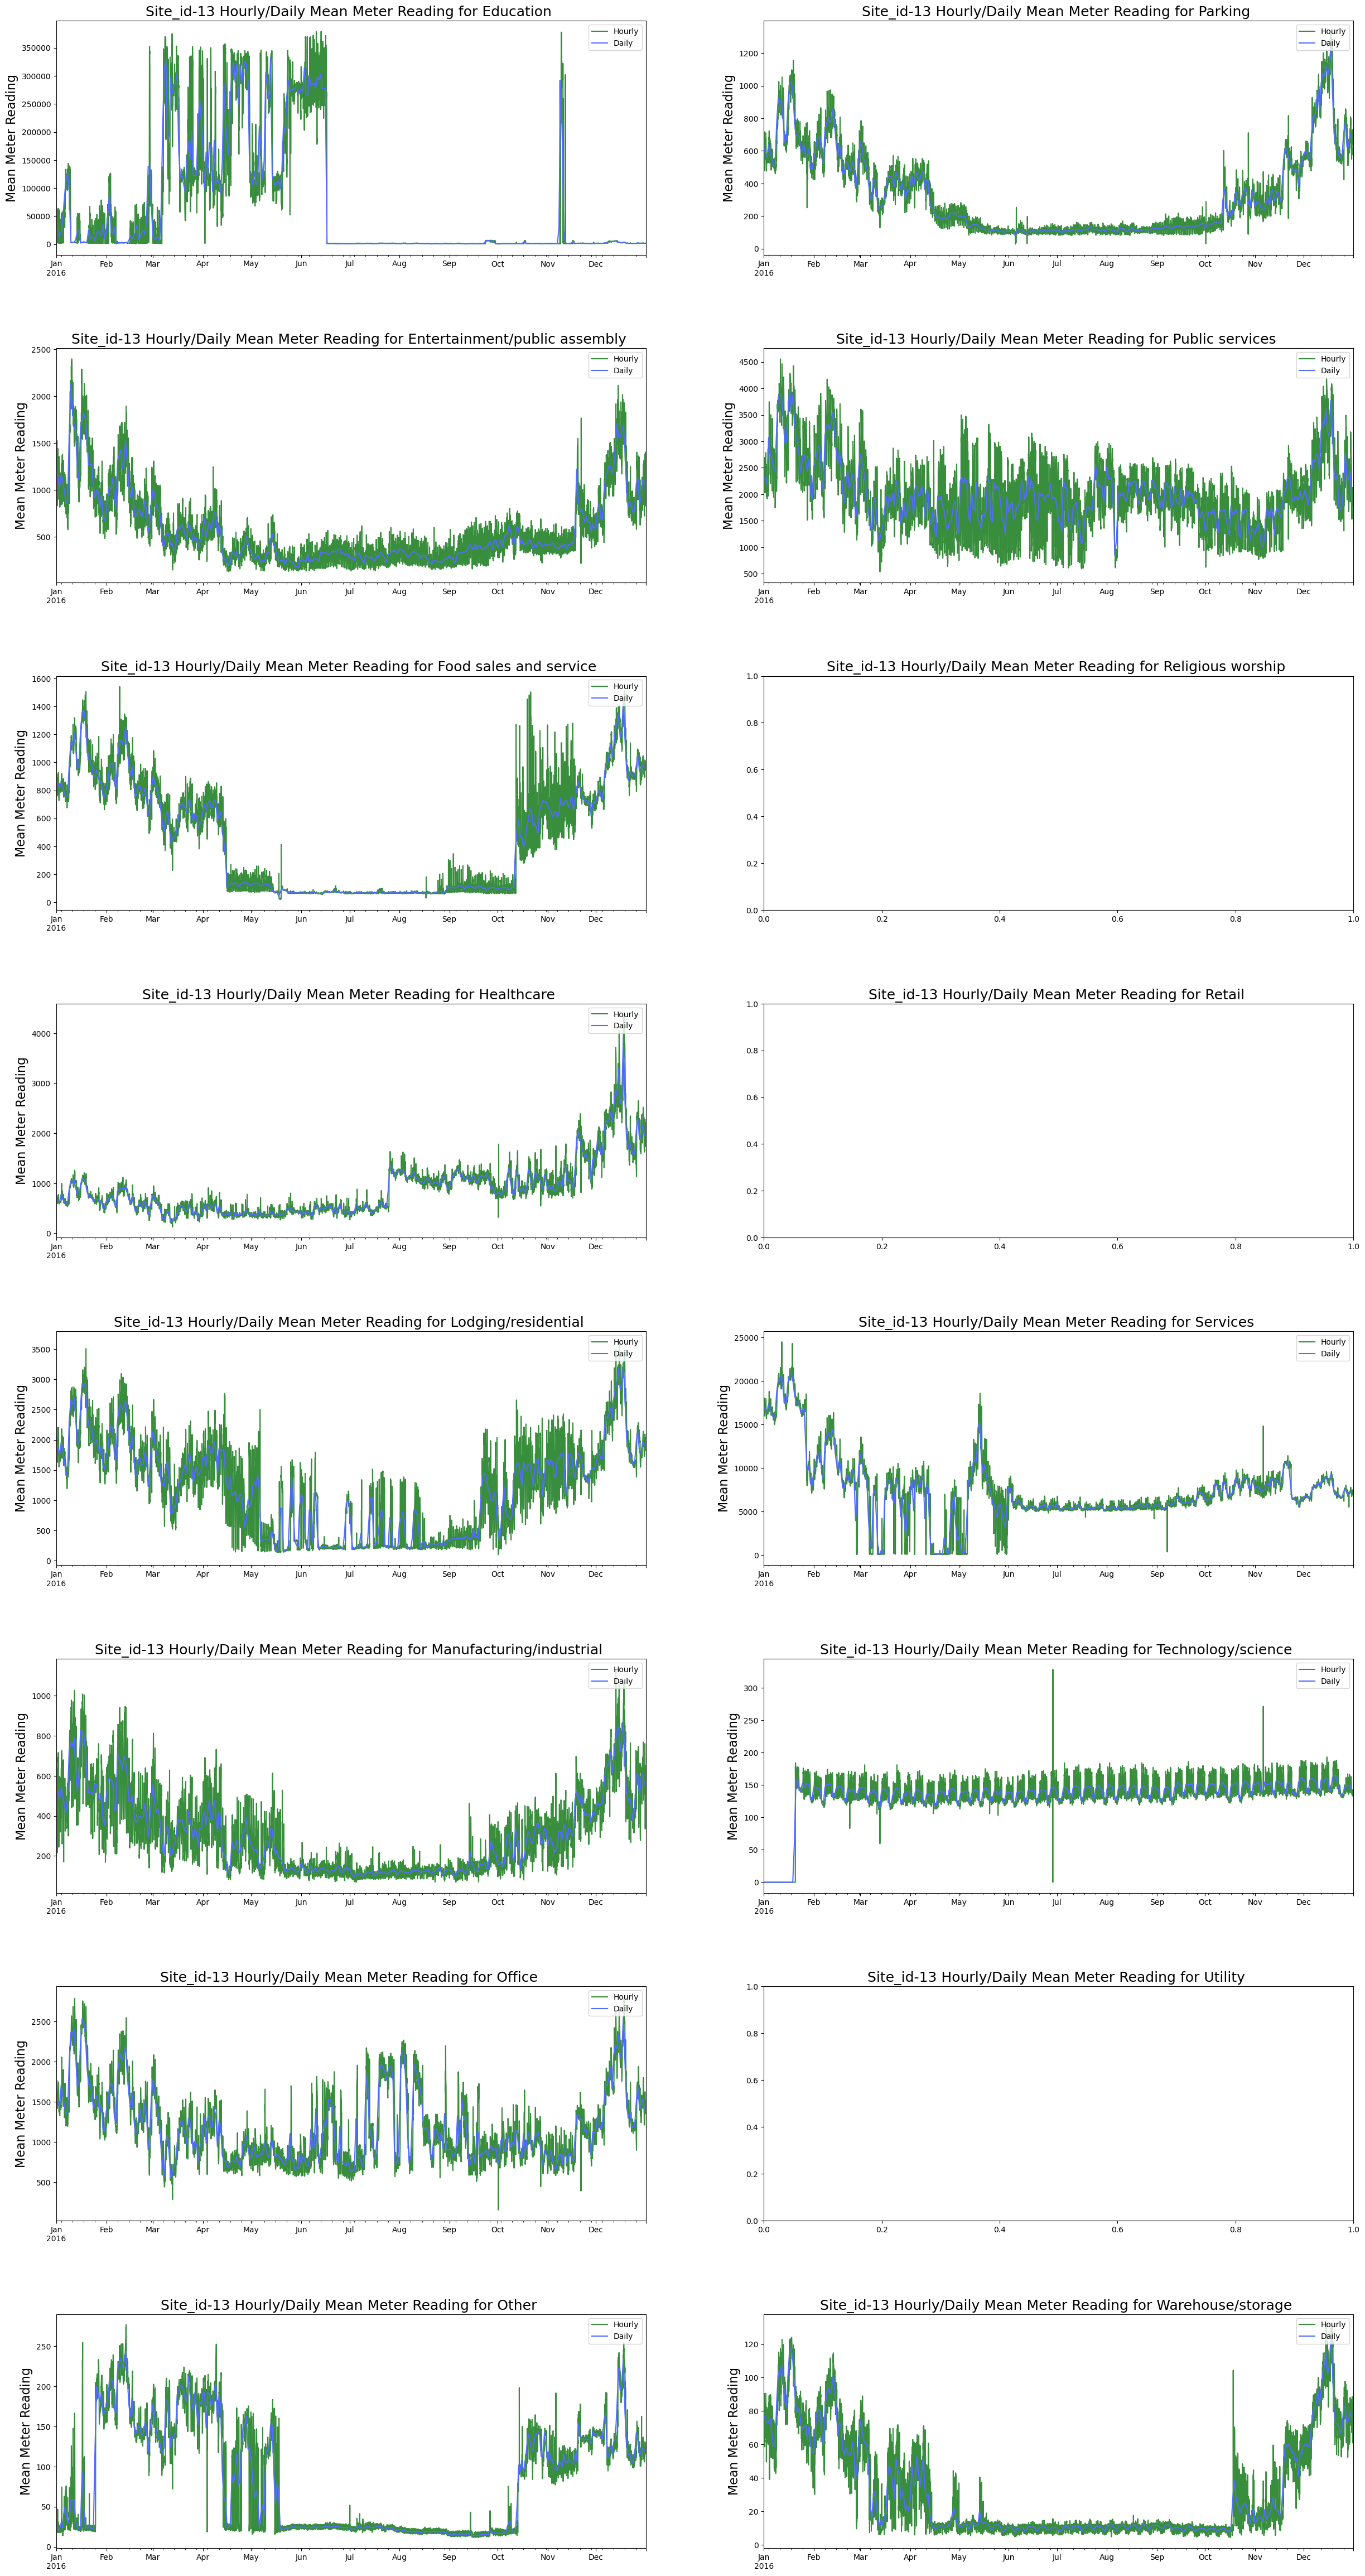

In [82]:
rows=8
cols=2
site =13
figure,axes = plt.subplots(rows,cols,figsize=(30,60),dpi=100)  # Set the whole figure size and subplots numbers 

primary_use= train['primary_use'].value_counts().sort_index().index.to_list() # save all primary use in an order to a list

for i,use in enumerate(primary_use):
    try:
        train[(train['site_id']==site) & (train['primary_use']==use)]['meter_reading'].resample(rule='H').mean().plot(ax=axes[i%rows][i//rows],label='Hourly',color='#388E3C').set_ylabel('Mean Meter Reading',fontsize=16)
        train[(train['site_id']==site) & (train['primary_use']==use)]['meter_reading'].resample(rule='D').mean().plot(ax=axes[i%rows][i//rows],label='Daily',color='#536DFE').set_xlabel('')
        axes[i%rows][i//rows].legend(loc='upper right')
    except TypeError:
        pass
    axes[i%rows][i//rows].set_title(f'Site_id-{site} Hourly/Daily Mean Meter Reading for {use} ',fontsize=18)
    plt.subplots_adjust(hspace=0.4)

<span style='color:red'>site_id=13 used for Education has quite similar trending shape of the whole training set meter reading plot </span>

#####  site_id =13 for Educational Use, Mean Meter Reading (Daily/Hourly) by Meter Type

In [62]:
train['meter'].value_counts().sort_index() # for all train set, there are in total 4 meter types

0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

In [73]:
train[(train['site_id']==13) & (train['primary_use']=='Education')]['meter'].value_counts().sort_index().index.to_list() 
# for site 13, Education use, only 3 types

[0, 1, 2]

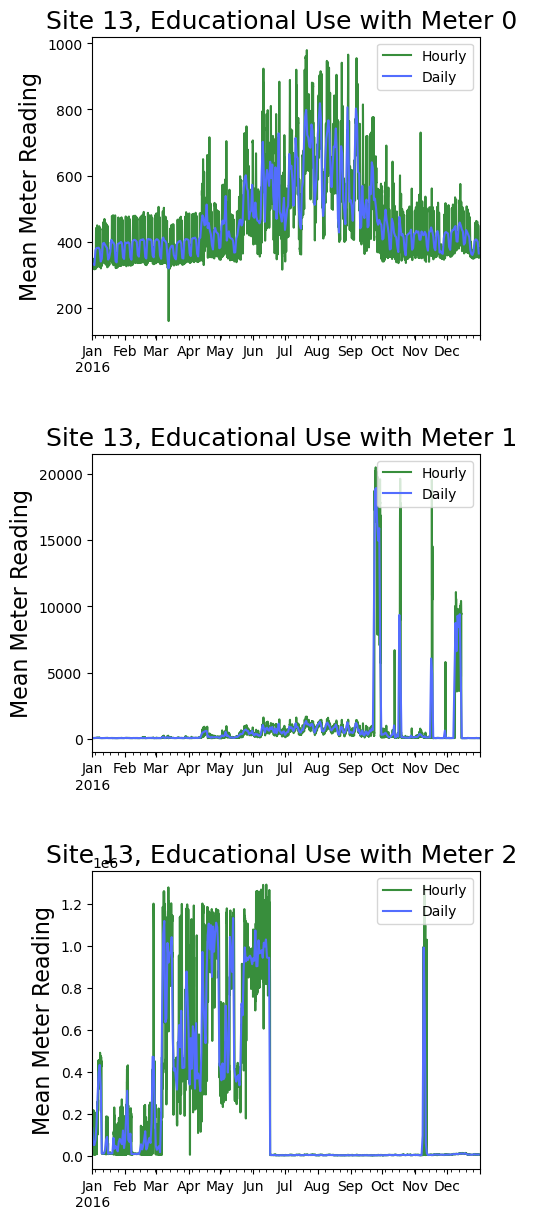

In [81]:
rows=3
cols=1
site =13
figure,axes = plt.subplots(rows,cols,figsize=(5,15),dpi=100)  # Set the whole figure size and subplots numbers 

#meter_type= train['meter'].value_counts().sort_index().index.to_list() # save all primary use in an order to a list

for i in range(3):
    train[(train['site_id']==site) & (train['primary_use']=='Education') & (train['meter']==i)]['meter_reading'].resample(rule='H').mean().plot(ax=axes[i],label='Hourly',color='#388E3C').set_ylabel('Mean Meter Reading',fontsize=16)
    train[(train['site_id']==site) & (train['primary_use']=='Education') & (train['meter']==i)]['meter_reading'].resample(rule='D').mean().plot(ax=axes[i],label='Daily',color='#536DFE').set_xlabel('')
    axes[i].legend(loc='upper right')
    axes[i].set_title(f'Site 13, Educational Use with Meter {i} ',fontsize=18)
    plt.subplots_adjust(hspace=0.4)

<span style='color:red'>Meter 2 has the similar trend as the training set. </span>

#####  site_id =13 + Educational Use + Meter 2  Mean Meter Reading (Daily/Hourly) by building_id

In [86]:
building_ids=train[(train['site_id']==13) & (train['primary_use']=='Education') & (train['meter']==2)]['building_id'].value_counts().sort_index().index.to_list()

In [88]:
len(building_ids)

17

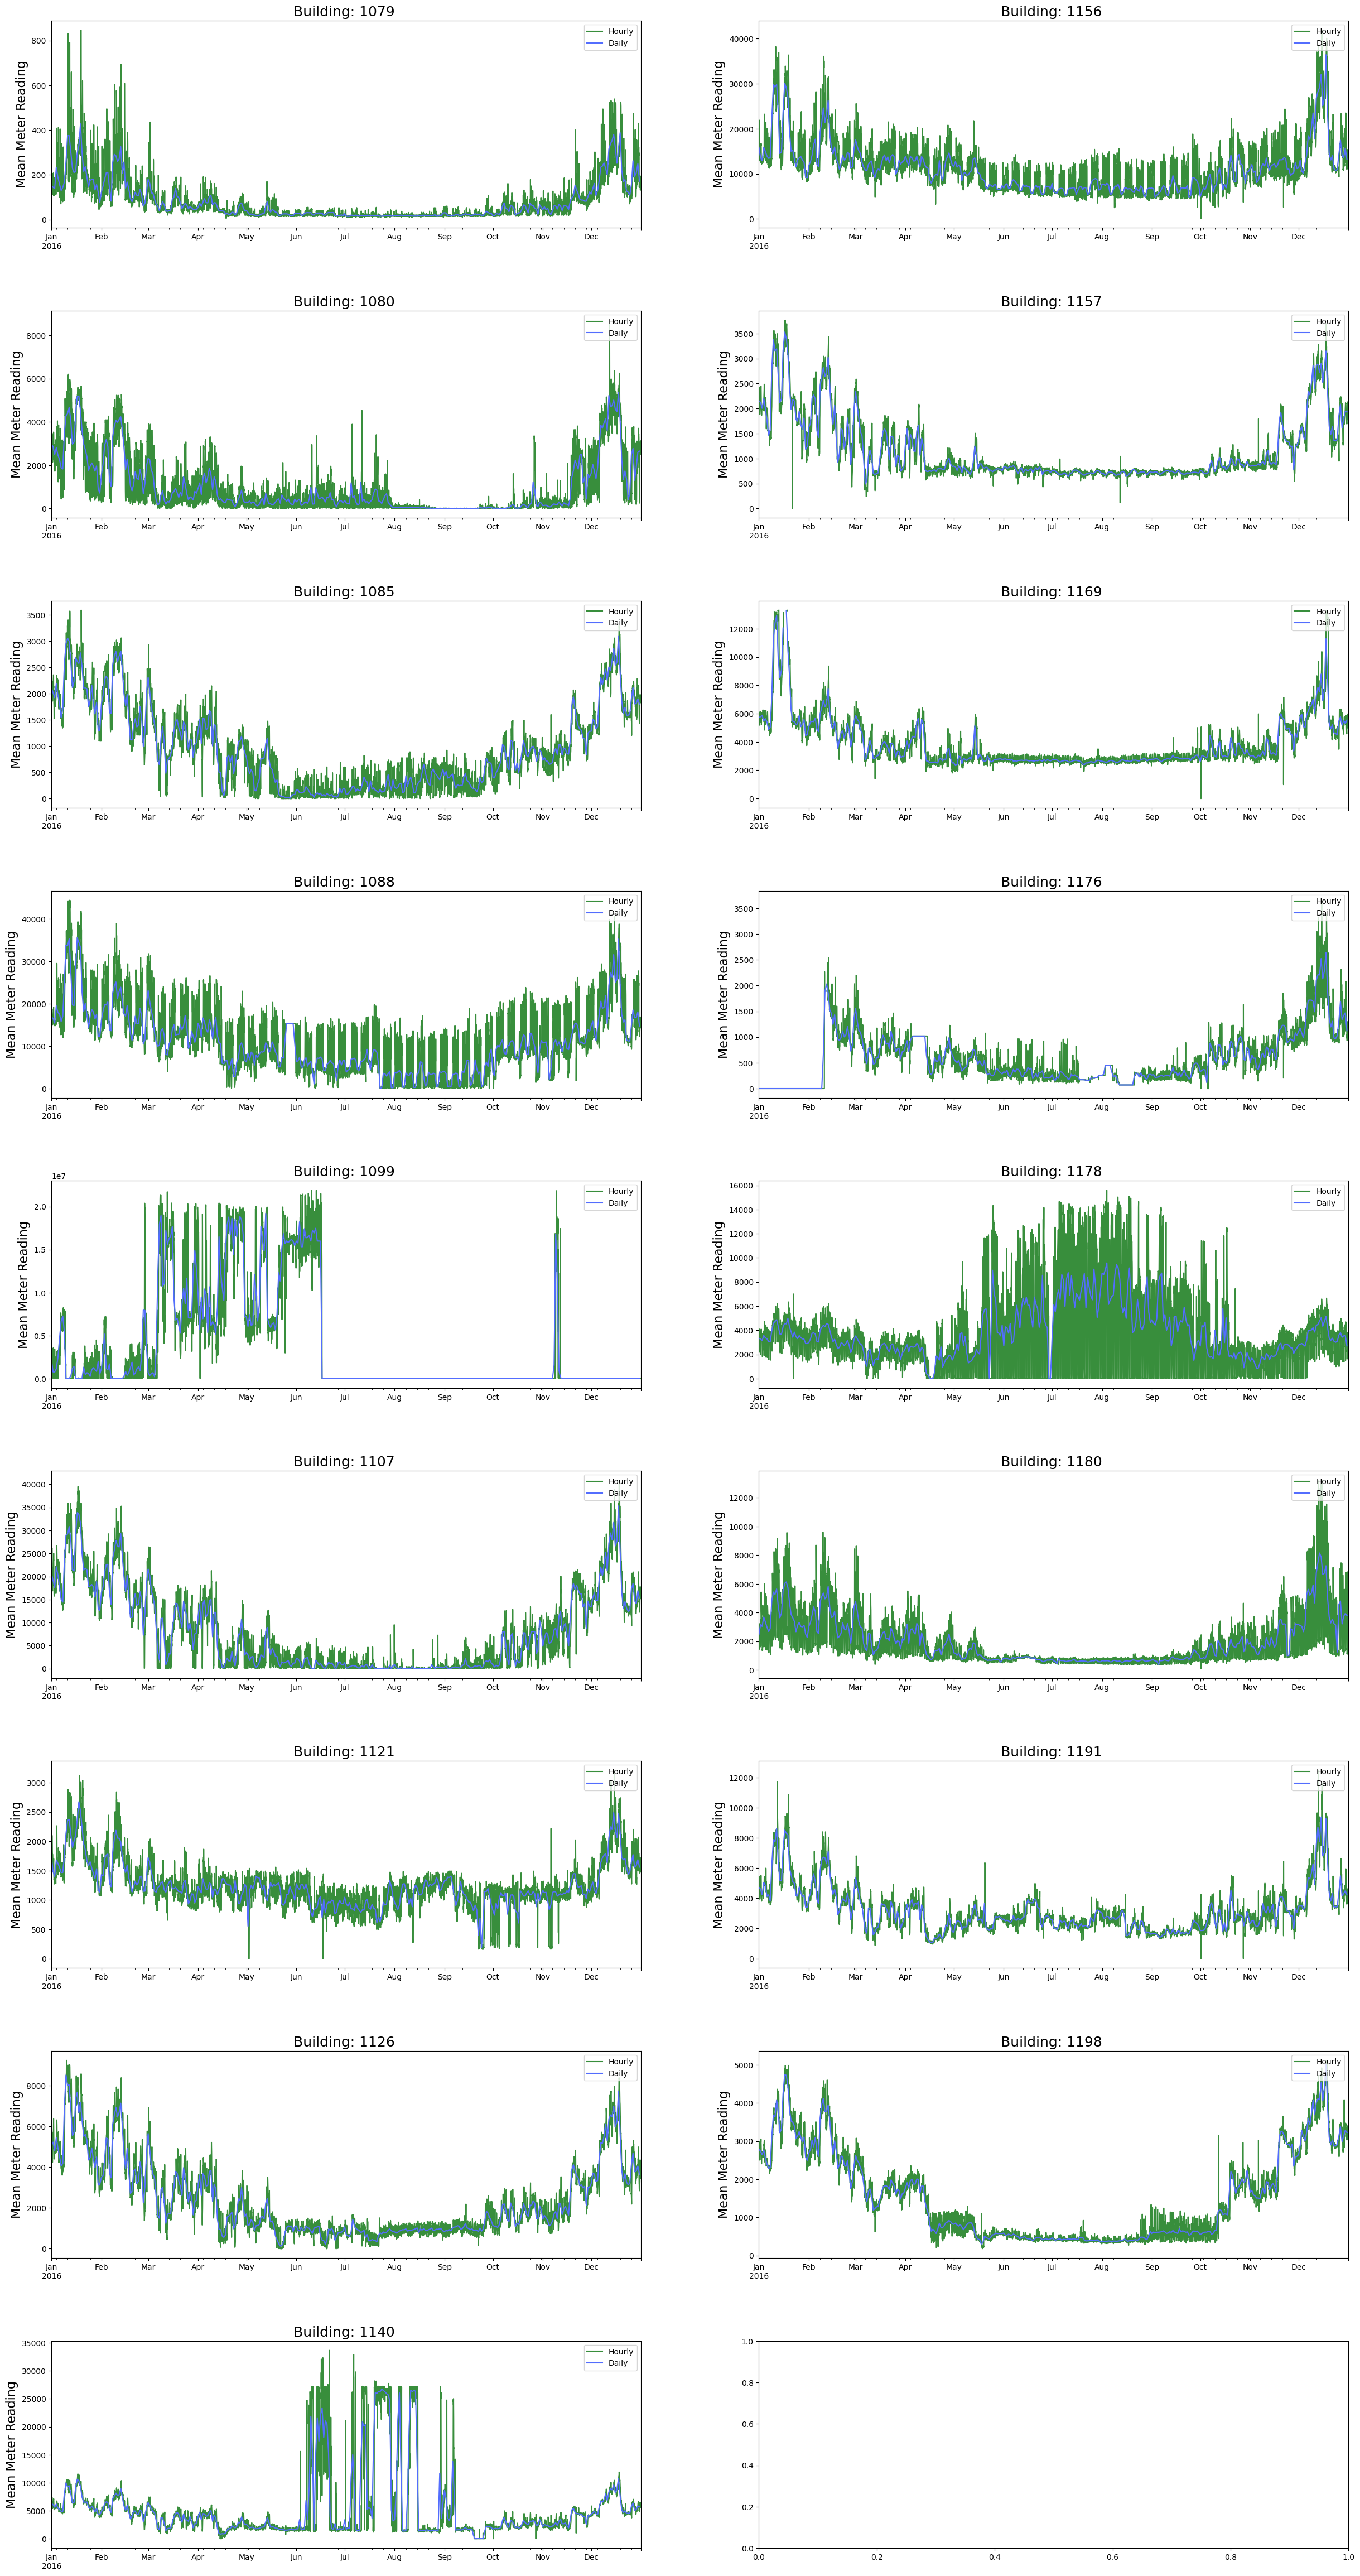

In [91]:
rows=9
cols=2
figure,axes = plt.subplots(rows,cols,figsize=(30,60),dpi=100)  # Set the whole figure size and subplots numbers
for i,building in enumerate(building_ids):
    train[(train['site_id']==13) & (train['primary_use']=='Education') & (train['meter']==2) & (train['building_id']==building)]['meter_reading'].resample(rule='H').mean().plot(ax=axes[i%rows][i//rows],label='Hourly',color='#388E3C').set_ylabel('Mean Meter Reading',fontsize=16)
    train[(train['site_id']==13) & (train['primary_use']=='Education') & (train['meter']==2) & (train['building_id']==building)]['meter_reading'].resample(rule='D').mean().plot(ax=axes[i%rows][i//rows],label='Daily',color='#536DFE').set_xlabel('')
    axes[i%rows][i//rows].legend(loc='upper right')
    axes[i%rows][i//rows].set_title(f'Building: {building} ',fontsize=18)
    plt.subplots_adjust(hspace=0.4)

<span style='color:red'> Building 1099 has the similar trend as the training set. </span>

#####  Inspect the influence of buidling 1099 on mean meter reading

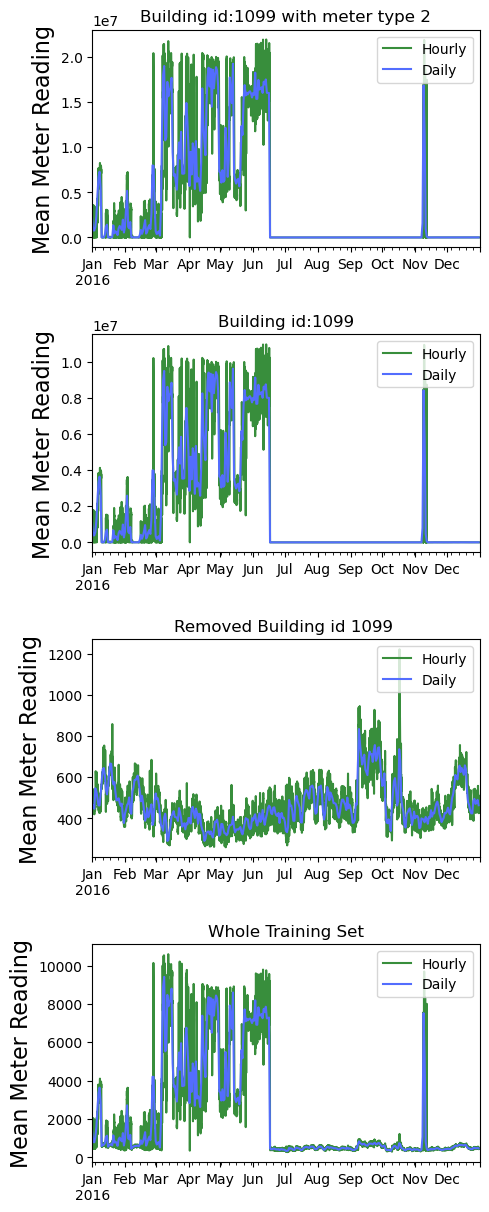

In [100]:
rows=4
cols=1
figuer,axes = plt.subplots(rows,cols,figsize=(5,15),dpi=100)

train[(train['building_id']==1099) & (train['meter']==2)]['meter_reading'].resample(rule='H').mean().plot(ax=axes[0],label='Hourly',color='#388E3C').set_ylabel('Mean Meter Reading',fontsize=16)
train[(train['building_id']==1099) & (train['meter']==2)]['meter_reading'].resample(rule='D').mean().plot(ax=axes[0],label='Daily',color='#536DFE').set_xlabel('')

train[(train['building_id']==1099)]['meter_reading'].resample(rule='H').mean().plot(ax=axes[1],label='Hourly',color='#388E3C').set_ylabel('Mean Meter Reading',fontsize=16)
train[(train['building_id']==1099)]['meter_reading'].resample(rule='D').mean().plot(ax=axes[1],label='Daily',color='#536DFE').set_xlabel('')

train[~(train['building_id']==1099)]['meter_reading'].resample(rule='H').mean().plot(ax=axes[2],label='Hourly',color='#388E3C').set_ylabel('Mean Meter Reading',fontsize=16)
train[~(train['building_id']==1099)]['meter_reading'].resample(rule='D').mean().plot(ax=axes[2],label='Daily',color='#536DFE').set_xlabel('')


train['meter_reading'].resample(rule='H').mean().plot(ax=axes[3],label='Hourly',color='#388E3C').set_ylabel('Mean Meter Reading',fontsize=16)
train['meter_reading'].resample(rule='D').mean().plot(ax=axes[3],label='Daily',color='#536DFE').set_xlabel('')

axes[0].legend(loc='upper right');
axes[1].legend(loc='upper right');
axes[2].legend(loc='upper right');
axes[3].legend(loc='upper right');

axes[0].set_title('Building id:1099 with meter type 2', fontsize=12);
axes[1].set_title('Building id:1099', fontsize=12);
axes[2].set_title('Removed Building id 1099 ', fontsize=12);
axes[3].set_title('Whole Training Set', fontsize=12);
plt.subplots_adjust(hspace=0.4)



In [101]:
train[train['building_id']==1099]['meter'].value_counts()

2    8784
0    8782
Name: meter, dtype: int64

<span style='color:red'> No matter what kind of meter used, building 1099 is the main reason for resulting in the abnormal distribution of mean meter reading. </span> \
By removing building 1099 from the training dataset, the mean meter-reading plotting seems to be more sensible (still has outliers)

##### <2> primary_use

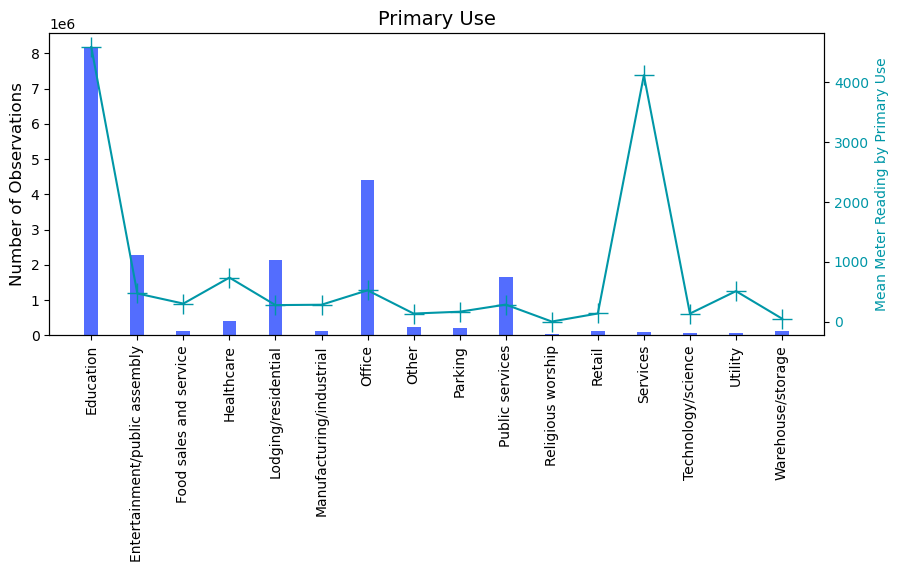

In [208]:
primary_use = train['primary_use'].value_counts().index.to_list()
# Only one figure
rows=1
cols=1
fig,axes = plt.subplots(rows,cols, figsize=(10,4),dpi=100)

# Bar Chart
ind = np.arange(len(primary_use))  # x loacations  
height = train['primary_use'].value_counts().sort_index().values  # Use sort_index to make sure the order of primary use 
width = 0.3   # bar width

axes.bar(x=ind,height=height,width=width,color='#536DFE')
axes.set_ylabel('Number of Observations',fontsize=12)
axes.set_xticks(ind)  # Put the label in the middle of each bar
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index,fontsize=10,rotation=90)
axes.set_title('Primary Use',fontsize=14)


# Create a twin x axis and a new y axis to add anothe plot
axes2 = axes.twinx()
axes2.plot(ind,train[['primary_use','meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values,
           marker='+',markersize=15,color='#0097A7')
axes2.set_ylabel('Mean Meter Reading by Primary Use',fontsize=10,color='#0097A7')
axes2.tick_params(axis='y', labelcolor='#0097A7');


#### (2) Features with Large Missing Values

Building info: floor_count, year_build missed a lot \
Weather info:  cloud_coverage, precip_depth_1_hr missed 

**<1> floor_count** 
\
floor count distribution\
mean meter reading for floor_count, the correlation is significant or not?\
how to impute?

Text(0.5, 1.0, 'Floor Count')

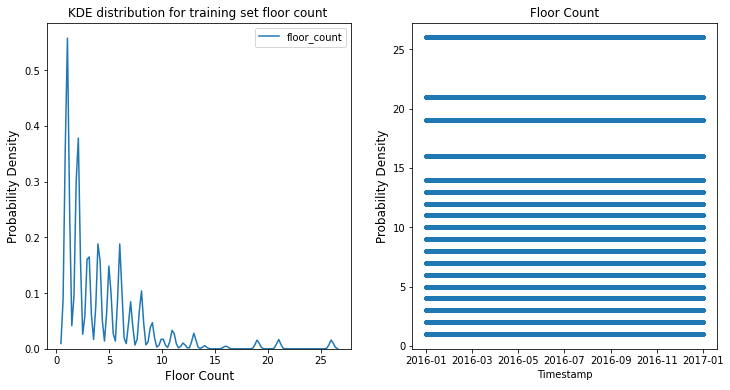

In [209]:
rows=1
cols=2
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

sns.kdeplot(train['floor_count'],ax=axes[0])
axes[1].plot(train['floor_count'],'.')
axes[0].set_xlabel('Floor Count',fontsize=12)
axes[0].set_ylabel('Probability Density',fontsize=12)
axes[0].set_title('KDE distribution for training set floor count ');

axes[1].set_xlabel('Timestamp'); #Already set timestamp as index
axes[1].set_ylabel('Probability Density',fontsize=12)
axes[1].set_title('Floor Count',fontsize=12)

In [172]:
floor_count_no_na=train['floor_count'].value_counts(dropna=True).sort_index()

In [173]:
floor_count_no_na.index=floor_count_no_na.index.astype(np.int8)

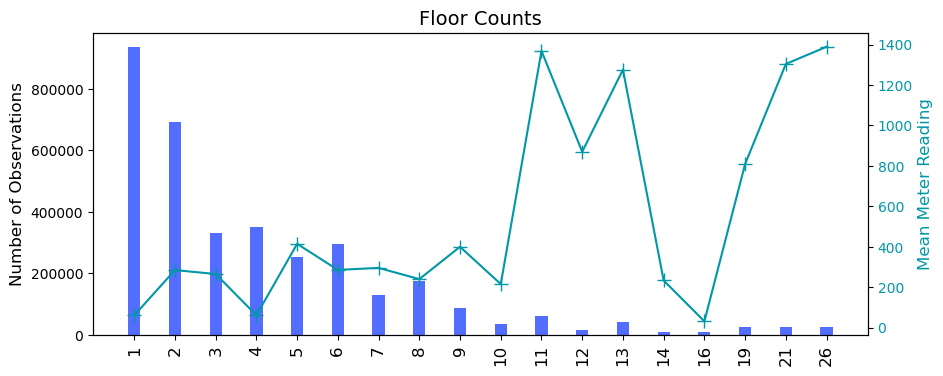

In [183]:
rows=1
cols=1
figure,axes = plt.subplots(rows,cols, figsize=(10,4),dpi=100)

# Bar Chart
ind = np.arange(len(floor_count_no_na))  # x loacations  
height = floor_count_no_na.values  # Use sort_index to make sure the order of primary use 
width = 0.3   # bar width

axes.bar(x=ind,height=height,width=width,color='#536DFE')
axes.set_ylabel('Number of Observations',fontsize=12)
axes.set_xticks(ind)  # Put the label in the middle of each bar
axes.set_xticklabels(floor_count_no_na.index,fontsize=12,rotation=90)
axes.set_title('Floor Counts',fontsize=14)

# Create a twin x axis and a new y axis to add anothe plot
axes2 = axes.twinx()
axes2.plot(ind,train[['floor_count','meter_reading']].groupby('floor_count')['meter_reading'].mean().sort_index().values,
           marker='+',markersize=10,color='#0097A7')
axes2.set_ylabel('Mean Meter Reading',fontsize=12,color='#0097A7')
axes2.tick_params(axis='y', labelcolor='#0097A7');


<span style='color:red'>The trending should be more floors, lager meter reading. However, for floor_counts =16, the mean meter reading is quite small.</span>

In [184]:
train['floor_count'].corr(train['meter_reading'])

0.13022433897741126

In [198]:
floor_count_mean_meter=pd.DataFrame(train[['floor_count','meter_reading']].groupby('floor_count')['meter_reading'].mean())

In [201]:
floor_count_mean_meter

meter_reading
floor_count               
1.0              60.314968
2.0             284.384705
3.0             264.816101
4.0              60.516243
5.0             414.146240
6.0             285.204437
7.0             295.051697
8.0             239.636139
9.0             399.497131
10.0            214.922150
11.0           1368.619629
12.0            869.610229
13.0           1275.924316
14.0            232.883698
16.0             30.878210
19.0            809.176514
21.0           1303.999756
26.0           1389.280518

**<2> year_built**

 year built distribution\
 mean meter reading for each built year, the correlation is significant or not?\
 for missing year_built, how to impute?

In [114]:
year_built_no_na=train['year_built'].value_counts(dropna=True).sort_index(ascending=True)

In [121]:
year_built_no_na.index=year_built_no_na.index.astype(np.int16)

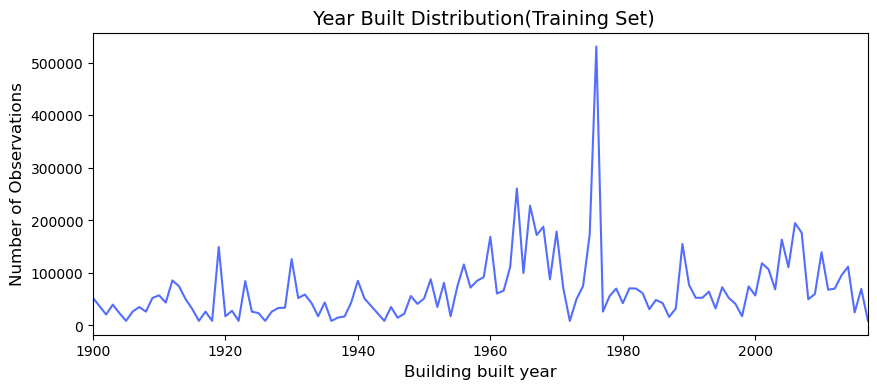

In [180]:
rows=1
cols=1
figur,axes = plt.subplots(rows,cols,figsize=(10,4),dpi=100)

year_built_no_na.plot(ax=axes,label='Train',color='#536DFE')
axes.set_xlabel('Building built year',fontsize=12)
axes.set_ylabel('Number of Observations',fontsize=12)
axes.set_title(' Year Built Distribution(Training Set)',fontsize=14);


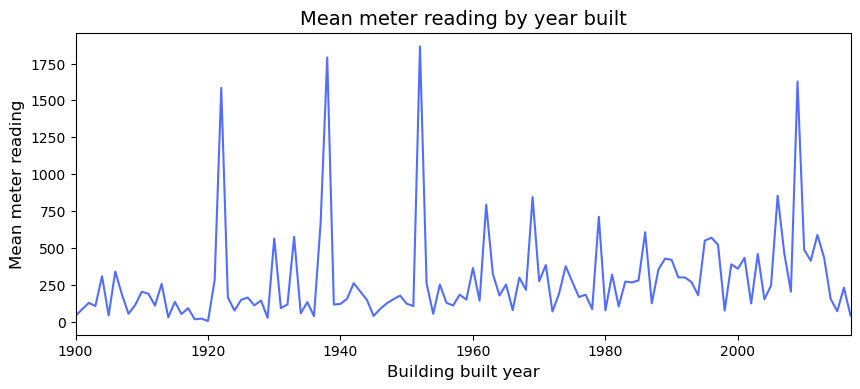

In [178]:
rows=1
cols=1
figure,axes = plt.subplots(rows,cols, figsize=(10,4),dpi=100)
train.groupby(['year_built'])['meter_reading'].mean().plot(ax=axes,color='#536DFE')
axes.set_xlabel('Building built year',fontsize=12)
axes.set_ylabel('Mean meter reading',fontsize=12)
axes.set_xlim(xmax=2017)
axes.set_title('Mean meter reading by year built',fontsize=14);


In [153]:
train['year_built'].corr(train['meter_reading'])# a weak correlation

0.11183692613509943

In [147]:
missing_year_site=train[train['year_built'].isnull()==True][['building_id','site_id']].groupby(['site_id']).count()

In [148]:
missing_year_site

building_id
site_id             
1             140530
2             581932
3            1236835
4               9795
5               8784
6             668133
7              25974
8             567915
9            2679323
10            411407
11            119459
12            315909
13           2711763
14           2501506
15            148380

**<3> cloud_coverage**

In [220]:
missing[missing['Variables']=='cloud_coverage']


Variables  Train Missing Percentage  Test Missing Percentage
3  cloud_coverage                    43.655                   46.866

In [233]:
cloud_coverage_no_na=train['cloud_coverage'].value_counts(dropna=True).sort_index()

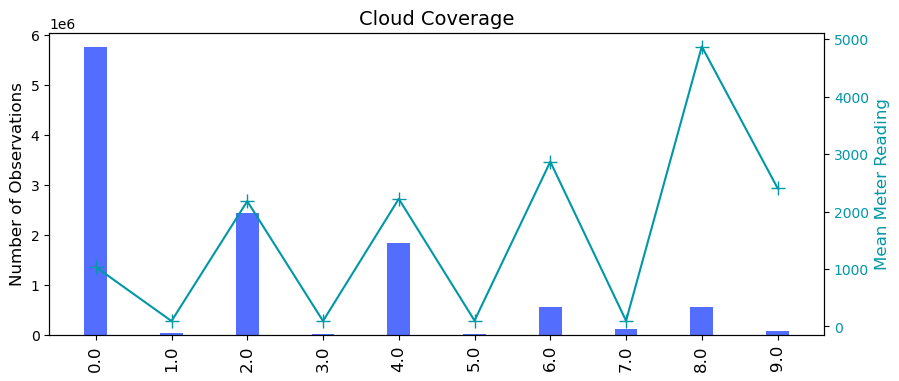

In [237]:
rows=1
cols=1
figure,axes = plt.subplots(rows,cols, figsize=(10,4),dpi=100)

# Bar Chart
ind = np.arange(len(cloud_coverage_no_na))  # x loacations  
height = cloud_coverage_no_na.values  # Use sort_index to make sure the order of primary use 
width = 0.3   # bar width

axes.bar(x=ind,height=height,width=width,color='#536DFE')
axes.set_ylabel('Number of Observations',fontsize=12)
axes.set_xticks(ind)  # Put the label in the middle of each bar
axes.set_xticklabels(cloud_coverage_no_na.index,fontsize=12,rotation=90)
axes.set_title('Cloud Coverage',fontsize=14)

# Create a twin x axis and a new y axis to add anothe plot
axes2 = axes.twinx()
axes2.plot(ind,train[['cloud_coverage','meter_reading']].groupby('cloud_coverage')['meter_reading'].mean().sort_index().values,
           marker='+',markersize=10,color='#0097A7')
axes2.set_ylabel('Mean Meter Reading',fontsize=12,color='#0097A7')
axes2.tick_params(axis='y', labelcolor='#0097A7');


In [238]:
train['cloud_coverage'].corr(train['meter_reading'])

0.006024124454630213

**<4> precip_depth_1_hr**

In [241]:
missing[missing['Variables']=='precip_depth_1_hr']

Variables  Train Missing Percentage  Test Missing Percentage
5  precip_depth_1_hr                    18.545                    18.71

In [242]:
train['precip_depth_1_hr'].value_counts().sort_index()

-1.0       1093352
 0.0      14517573
 2.0         33970
 3.0        255539
 4.0          1895
 5.0        119239
 6.0          2506
 7.0          6657
 8.0         72511
 9.0           999
 10.0        60741
 11.0         1058
 12.0         2247
 13.0        43236
 14.0          547
 15.0        34040
 16.0          503
 17.0         3408
 18.0        29124
 19.0          223
 20.0        22384
 21.0          556
 22.0          814
 23.0        14715
 24.0          112
 25.0        12936
 26.0          167
 27.0          667
 28.0         9780
 29.0          112
            ...   
 150.0         590
 152.0         197
 155.0         502
 160.0         502
 162.0          54
 163.0         168
 164.0          54
 165.0         479
 175.0         309
 180.0         246
 191.0         198
 193.0         882
 196.0         196
 198.0         347
 201.0          54
 203.0        1117
 211.0         245
 216.0         618
 217.0          55
 221.0         196
 234.0         194
 236.0      

<span style='color:red'>1093352 record of value -1.0</span>     \
Negative rain fall occurs when a particular area experiences more atmospheric evaporation than water downpour over a period of time. The phenomenon usually occurs when temperatures are unusually high, and precipitation is unusually low for the season.

In [248]:
train.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')

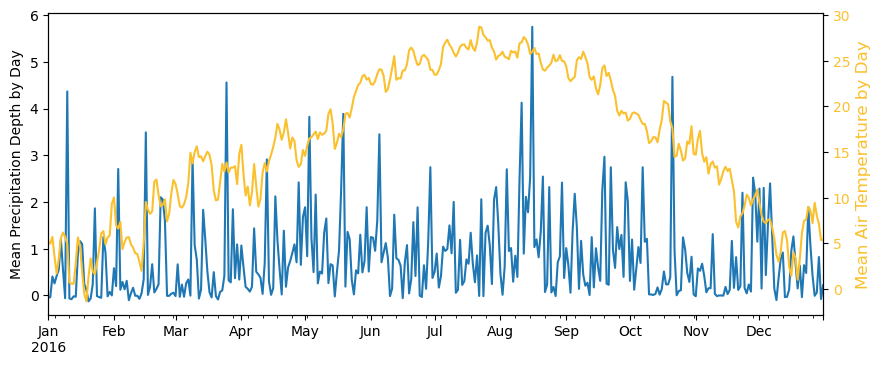

In [254]:
rows=1
cols=1
figure,axes= plt.subplots(rows,cols,figsize=(10,4),dpi=100)
train['precip_depth_1_hr'].resample(rule='D').mean().plot(ax=axes)
axes.set_xlabel('')
axes.set_ylabel('Mean Precipitation Depth by Day')

axes2 = axes.twinx()
train['air_temperature'].resample(rule='D').mean().plot(ax=axes2,color='#FBC02D')
axes2.set_ylabel('Mean Air Temperature by Day',fontsize=12,color='#FBC02D')
axes2.tick_params(axis='y', labelcolor='#FBC02D');

In [263]:
train.iloc[-100:].index

DatetimeIndex(['2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-

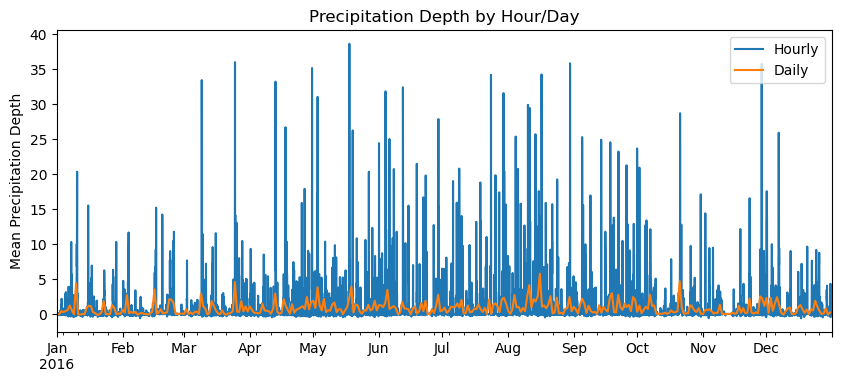

In [280]:
rows=1
cols=1
figure,axes= plt.subplots(rows,cols,figsize=(10,4),dpi=100)
train['precip_depth_1_hr'].resample(rule='H').mean().plot(ax=axes,label='Hourly')
train['precip_depth_1_hr'].resample(rule='D').mean().plot(ax=axes,label='Daily')
axes.set_xlabel('')
axes.set_ylabel('Mean Precipitation Depth')
axes.set_title('Precipitation Depth by Hour/Day')
axes.legend(loc='upper right');

#### (3) Weather Info

**<1> air_temperature**

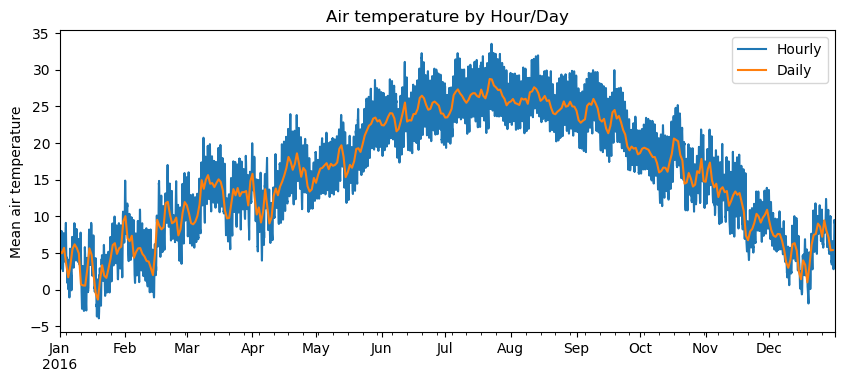

In [282]:
rows=1
cols=1
figure,axes= plt.subplots(rows,cols,figsize=(10,4),dpi=100)
train['air_temperature'].resample(rule='H').mean().plot(ax=axes,label='Hourly')
train['air_temperature'].resample(rule='D').mean().plot(ax=axes,label='Daily')
axes.set_xlabel('')
axes.set_ylabel('Mean air temperature')
axes.set_title('Air temperature by Hour/Day')
axes.legend(loc='upper right');

In [315]:
air_temperature_id=train.groupby('site_id')['air_temperature'].agg(np.mean)

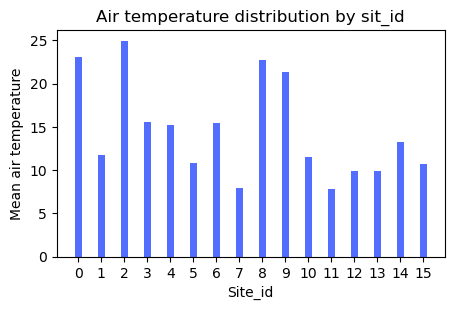

In [316]:
rows=1
cols=1
figure,axes = plt.subplots(rows,cols, figsize=(5,3),dpi=100)

# Bar Chart
ind = np.arange(len(air_temperature_id))  # x loacations  
height = air_temperature_id.values  # Use sort_index to make sure the order of primary use 
width = 0.3   # bar width

axes.bar(x=ind,height=height,width=width,color='#536DFE')
axes.set_xlabel('Site_id',fontsize=10)
axes.set_ylabel('Mean air temperature',fontsize=10)
axes.set_xticks(ind)  # Put the label in the middle of each bar
axes.set_xticklabels(dew_temperature_id.index,fontsize=10)
axes.set_title('Air temperature distribution by sit_id',fontsize=12);

**<2> dew_temperature**

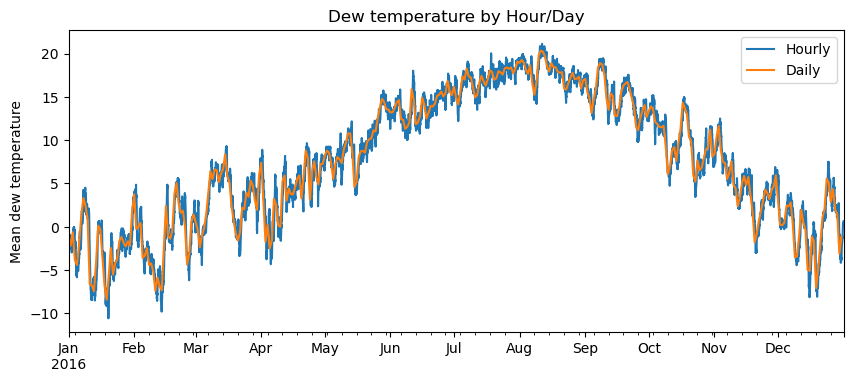

In [283]:
rows=1
cols=1
figure,axes= plt.subplots(rows,cols,figsize=(10,4),dpi=100)
train['dew_temperature'].resample(rule='H').mean().plot(ax=axes,label='Hourly')
train['dew_temperature'].resample(rule='D').mean().plot(ax=axes,label='Daily')
axes.set_xlabel('')
axes.set_ylabel('Mean dew temperature')
axes.set_title('Dew temperature by Hour/Day')
axes.legend(loc='upper right');

In [306]:
dew_temperature_id=train.groupby('site_id')['dew_temperature'].agg(np.mean)

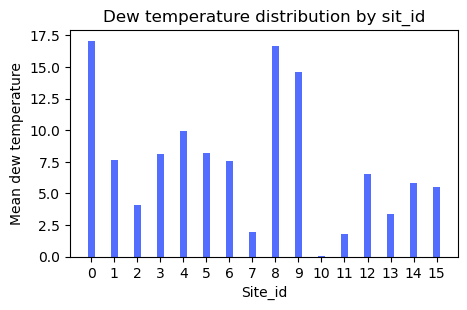

In [311]:
rows=1
cols=1
figure,axes = plt.subplots(rows,cols, figsize=(5,3),dpi=100)

# Bar Chart
ind = np.arange(len(dew_temperature_id))  # x loacations  
height = dew_temperature_id.values  # Use sort_index to make sure the order of primary use 
width = 0.3   # bar width

axes.bar(x=ind,height=height,width=width,color='#536DFE')
axes.set_xlabel('Site_id',fontsize=10)
axes.set_ylabel('Mean dew temperature',fontsize=10)
axes.set_xticks(ind)  # Put the label in the middle of each bar
axes.set_xticklabels(dew_temperature_id.index,fontsize=10)
axes.set_title('Dew temperature distribution by sit_id',fontsize=12);

In [310]:
dew_temperature_id.iloc[10]

0.0328

<span style='color:red'>site 10 has pretty low dew temperature</span>  \
how much moisture is in the air: the higher the dew point temperature, the greater the atmospheric moisture content.

In [319]:
train[train['site_id']==10]['meter_reading'].mean()

463.9599914550781

In [320]:
train[train['site_id']==0]['meter_reading'].mean()

549.7921752929688

In [321]:
train[train['site_id']==2]['meter_reading'].mean()

183.55055236816406

**<3> sea_level_pressure**

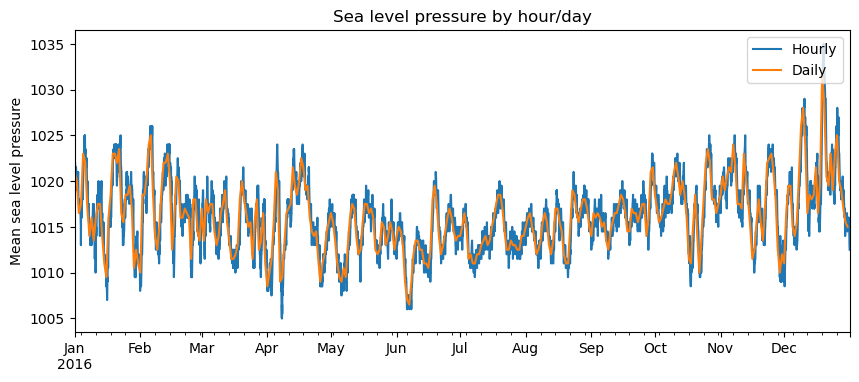

In [314]:
rows=1
cols=1
figure,axes= plt.subplots(rows,cols,figsize=(10,4),dpi=100)
train['sea_level_pressure'].resample(rule='H').mean().plot(ax=axes,label='Hourly')
train['sea_level_pressure'].resample(rule='D').mean().plot(ax=axes,label='Daily')
axes.set_xlabel('')
axes.set_ylabel('Mean sea level pressure')
axes.set_title('Sea level pressure by hour/day')
axes.legend(loc='upper right');

In [298]:
sea_level_pressure_id=train.groupby('site_id')['sea_level_pressure'].agg(np.mean)

Text(0.5, 1.0, 'Sea level pressure distribution by site_id')

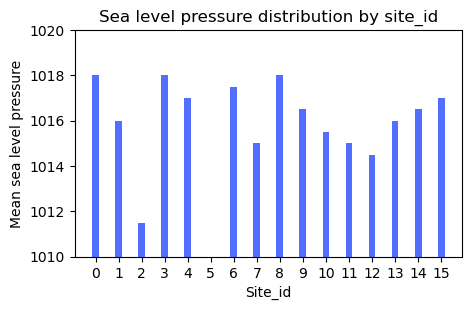

In [313]:
rows=1
cols=1
figure,axes = plt.subplots(rows,cols, figsize=(5,3),dpi=100)

# Bar Chart
ind = np.arange(len(sea_level_pressure_id))  # x loacations  
height = sea_level_pressure_id.values  # Use sort_index to make sure the order of primary use 
width = 0.3   # bar width

axes.bar(x=ind,height=height,width=width,color='#536DFE')
axes.set_xlabel('Site_id',fontsize=10)
axes.set_ylabel('Mean sea level pressure',fontsize=10)
axes.set_xticks(ind)  # Put the label in the middle of each bar
axes.set_xticklabels(sea_level_pressure_id.index,fontsize=10)
axes.set_ylim(bottom=1010,top=1020)
axes.set_title('Sea level pressure distribution by site_id',fontsize=12)

In [290]:
train.groupby('site_id')['sea_level_pressure'].agg(np.mean)

site_id
0     1018.0
1     1016.0
2     1011.5
3     1018.0
4     1017.0
5        NaN
6     1017.5
7     1015.0
8     1018.0
9     1016.5
10    1015.5
11    1015.0
12    1014.5
13    1016.0
14    1016.5
15    1017.0
Name: sea_level_pressure, dtype: float16

<span style='color:red'>site 5 has no record of sea_level_pressure</span> 

#### **<4> wind_speed**

In [323]:
train['wind_speed'].value_counts()

0.000000     2384761
2.099609     2321511
2.599609     2198529
1.500000     2085450
3.099609     1982520
3.599609     1763771
4.101562     1444740
4.601562     1218248
5.101562      965281
5.699219      773742
6.199219      638804
6.699219      484840
7.199219      387916
7.699219      272850
8.203125      207660
8.796875      154213
9.296875      107417
1.000000       86695
9.796875       73204
4.000000       50806
10.296875      49227
5.000000       48822
6.000000       41416
3.000000       40740
0.500000       39522
10.796875      39190
7.000000       31219
11.296875      28507
2.000000       24058
8.000000       21945
11.796875      18576
9.000000       16148
12.398438      12247
10.000000      11205
12.898438       8064
11.000000       7443
13.398438       6032
13.898438       4394
12.000000       4279
14.398438       2806
13.000000       2770
14.898438       1963
15.398438       1665
8.703125        1626
14.000000       1294
16.000000       1135
2.199219         888
15.000000    

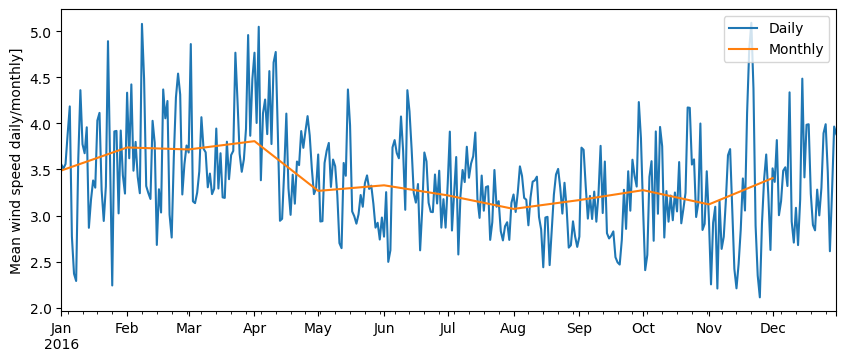

In [332]:
rows=1
cols=1
figure,axes= plt.subplots(rows,cols,figsize=(10,4),dpi=100)
train['wind_speed'].resample(rule='D').mean().plot(ax=axes,label='Daily')
train['wind_speed'].resample(rule='M').mean().plot(ax=axes,label='Monthly')
axes.set_xlabel('')
axes.set_ylabel('Mean wind speed daily/monthly]')
axes.legend(loc='upper right');



**<5> wind_direction**

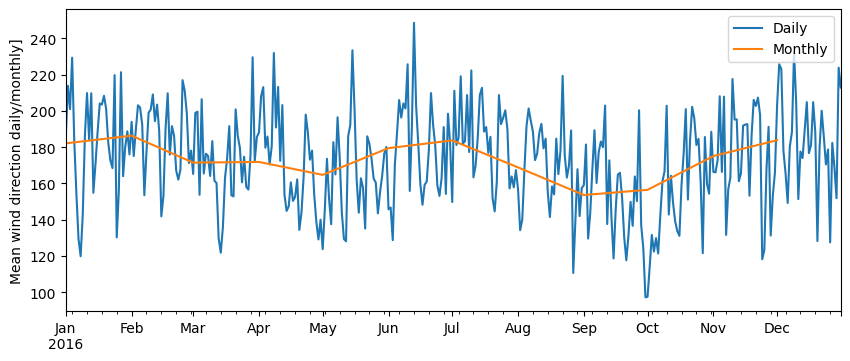

In [333]:
rows=1
cols=1
figure,axes= plt.subplots(rows,cols,figsize=(10,4),dpi=100)
train['wind_direction'].resample(rule='D').mean().plot(ax=axes,label='Daily')
train['wind_direction'].resample(rule='M').mean().plot(ax=axes,label='Monthly')
axes.set_xlabel('')
axes.set_ylabel('Mean wind direction daily/monthly]')
axes.legend(loc='upper right');



### 4.3 Correlation --Pearson Correlation Coefficient

In [44]:
np.log1p(1e-20)

1e-20

In [45]:
np.log(1e-20+1)

0.0

In [47]:
mask = np.zeros_like(train.corr())
triangle_indices=np.triu_indices_from(mask)
mask[triangle_indices]=True

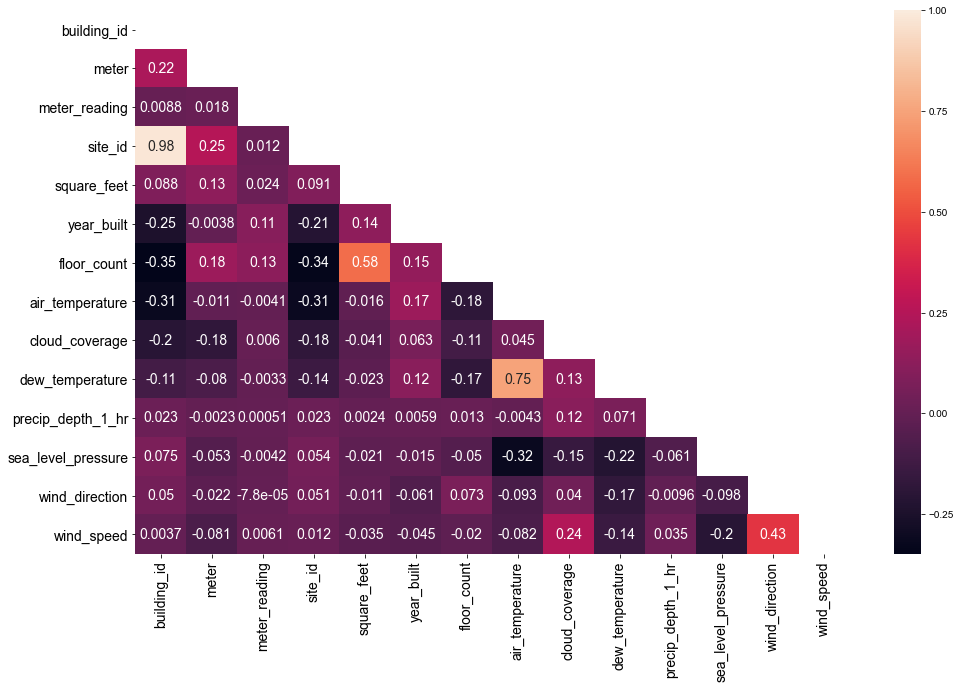

In [48]:
plt.figure(figsize=(16,10))
sns.heatmap(data=train.corr(),mask=mask,annot=True,annot_kws={'size':14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Detect Multicollinearity---<span style='color:red'>Notice that Pearson correlation only valid for continuous variables. </span> \
Later those highly correlated variables can be removed for preparing training set.\
<span style='color:red'>site_id-----building_id---0.98 But they are not continuous variables </span> \
air_temperature---dew_temperature---0.75\
square_feet----floor_count----0.58 \
wind_direction---wind_speed---0.43